<a href="https://colab.research.google.com/github/VladKarad/AI_education/blob/main/Mnist_Autoencoder_architecture_HW_Pro.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Задание Pro


Обучите автокодировщик на 10 красивых цифрах 5 из mnist и отредактируйте с помощью него все остальные цифры 5.

Алгоритм действий:
1. Выберите 10 самых красивых по вашем мнению пятерок в тренировочной выборке mnist. 
2. Создайте датасет, где объекты – это все пятерки из тренировочной части mnist, а метки – это случайные пятерки из "красивого" набора. 
3. Создайте автокодировщик и проверьте, совпадают ли у него размеры выхода и входа.
4. Обучите автокодировщик.
5. Добейтесь ошибки MSE на тренировочной выборке **<0.05**. 
6. Посмотрите, как выглядят пятерки из тестовой выборки после обученного автокодировщика.

## Импорт библиотек

In [ ]:
# Для операций с тензорами
import numpy as np

# Для отрисвоки
import matplotlib.pyplot as plt

# Для создания модели
from tensorflow.keras.models import Model

# Необходимые слои
from tensorflow.keras.layers import Input, Conv2DTranspose, MaxPooling2D, Conv2D, BatchNormalization

# Слои для латентного пространства модели
from tensorflow.keras.layers import Flatten, Reshape, Dense

# Оптимизатор
from tensorflow.keras.optimizers import Adam

# Для загрузки базы
from tensorflow.keras.datasets import mnist

## Загрузка данных

In [ ]:
# Загрузка датасета
(X_train, y_train), (X_test, y_test) = mnist.load_data()

11501568/11490434 [==============================] - 0s 0us/step


In [ ]:
# Нормализация данных
X_train = X_train.astype('float32')/255.
X_test = X_test.astype('float32')/255.

In [ ]:
# Приведение формы к удобной для Keras
X_train = X_train.reshape(-1, 28, 28, 1)
X_test = X_test.reshape(-1, 28, 28, 1)

In [ ]:
# Отбор пятерок
mask = y_train == 5
X_train = X_train[mask]
y_train = y_train[mask]

In [ ]:
# Аналогично для тестирования
mask = y_test == 5
X_test = X_test[mask]
y_test = y_test[mask]

## Отбор красивых пятерок

In [ ]:
#########################################################
###             МЕСТО ДЛЯ ВАШЕГО КОДА              ###
#########################################################

In [ ]:
X_test[0].shape

(28, 28, 1)

In [ ]:
a = X_test.reshape(892,28,28)

In [ ]:
a[1].shape

(28, 28)

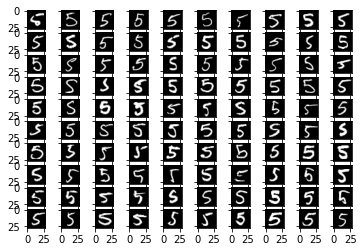

In [ ]:
fig, subplots = plt.subplots(nrows=10, ncols=10, sharex=True, sharey=True)
i = -1
for ax in fig.axes:
  i += 1
  ax.imshow(a[i], cmap=plt.get_cmap('gray'))
plt.show()


In [ ]:
y_true = []
cool = (8,15,20,36,42,58,69,75,88,97)
for i in cool:
  y_true.append(X_test[i])
y_true = np.array(y_true).astype('float32')

In [ ]:
y_true[1].shape


(28, 28, 1)

In [ ]:
y_train.shape

(5421,)

In [ ]:
X_train[:100].shape

(100, 28, 28, 1)

In [ ]:
import random

In [ ]:
Y_true = []
for i in range(X_train.shape[0]):
  j = random.randint(0,9)
  Y_true.append(y_true[j])
Y_true = np.array(Y_true).astype('float32')

In [ ]:
Y_true.shape

(5421, 28, 28, 1)

In [ ]:
# Функция последовательного вывода нескольких изображений для сравнения
def plot_images(x_data, pred, n=5): 

    plt.figure(figsize=(14, 7))                     # Размер полотна

    for i in range(1, n + 1):                              # Повтор n раз:
        index = np.random.randint(0, pred.shape[0]) # Выбор случайного индекса 

        # Показ картинки с индексом index из набора x_data
        ax = plt.subplot(2, n, i)               # Картинка располагается в верхнем ряду
        plt.imshow(x_data[index].squeeze(), cmap='gray')
        ax.get_xaxis().set_visible(False) 
        ax.get_yaxis().set_visible(False) 

        # Показ картинки с тем же индексом из предсказания автокодировщика
        ax = plt.subplot(2, n, i + n)           # Картинка располагается в нижнем ряду
        plt.imshow(pred[index].squeeze(), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    plt.show()

In [ ]:
# Функция сборки сверточного автокодировщика
def create_base_ae(in_shape):
    # Энкодер, вход нейросети
    img_input = Input(in_shape)

    # Энкодер, первый блок
    # 1.1. Двумерная свертка
    x = Conv2D(32, (3, 3), padding='same', activation='relu')(img_input) 
    # 1.2. Нормализация
    x = BatchNormalization()(x)
    # 1.3. Двумерная свертка
    x = Conv2D(32, (3, 3), padding='same', activation='relu')(x) 
    # 1.4. Нормализация
    x = BatchNormalization()(x)
    # 1.5. Снижение размерности и обобщение данных
    x = MaxPooling2D()(x)

    # Энкодер, второй блок
    # 2.1. Двумерная свертка
    x = Conv2D(64, (3, 3), padding='same', activation='relu')(x) 
    # 2.2. Нормализация
    x = BatchNormalization()(x)
    # 2.3. Двумерная свертка
    x = Conv2D(64, (3, 3), padding='same', activation='relu')(x)
    # 2.4. Нормализация
    x = BatchNormalization()(x)
    # 2.5. Снижение размерности и обобщение данных
    z = MaxPooling2D()(x)
    
    # На выходе кодировщика и на входе декодировщика z - вектор латентного пространства

    # Декодер, первый блок
    # 1.1. Транспонированная свертка - повышение размерности данных
    x = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same', activation='relu')(z)
    # 1.2. Нормализация
    x = BatchNormalization()(x) 
    # 1.3. Двумерная свертка
    x = Conv2D(64, (3, 3), padding='same', activation='relu')(x)
    # 1.4. Нормализация
    x = BatchNormalization()(x) 
    # 1.5. Двумерная свертка
    x = Conv2D(64, (3, 3), padding='same', activation='relu')(x)
    # 1.6. Нормализация
    x = BatchNormalization()(x)

    # Декодер, второй блок
    # 2.1. Транспонированная свертка - повышение размерности данных
    x = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same', activation='relu')(x) 
    # 2.2. Нормализация
    x = BatchNormalization()(x) # слой нормализации данных
    # 2.3. Двумерная свертка
    x = Conv2D(32, (3, 3), padding='same', activation='relu')(x) 
    # 2.4. Нормализация
    x = BatchNormalization()(x) # слой нормализации данных
    # 2.5. Двумерная свертка
    x = Conv2D(32, (3, 3), padding='same', activation='relu')(x) 
    # 2.6. Нормализация
    x = BatchNormalization()(x) 

    # Декодер, финальный слой двумерной свертки, выдающий итоговое изображение
    outputs = Conv2D(in_shape[-1], (3, 3), activation='sigmoid', padding='same')(x)

    # Сборка модели, на входе оригинальное изображение, на выходе - сжатое-восстановленное
    model = Model(inputs=img_input, outputs=outputs) 

    # Компиляция сети, назначение оптимизатора Adam + среднеквадратическая ошибка
    model.compile(optimizer=Adam(learning_rate=0.0001), loss='mse') 

    # Возврат готовой модели
    return model 

In [ ]:
# Разделение набора данных на обучающую и проверочную выборки

x_train_mnist = X_train[1080:]
y_train_mnist = Y_true[1080:]
x_test_mnist1 = X_train[:540]
y_test_mnist1 = Y_true[:540]
x_test_mnist =  X_train[540:1080]
y_test_mnist =  Y_true[540:1080]

In [ ]:
# Сборка автокодировщика для формы картинок датасета
ae_mnist = create_base_ae(x_train_mnist.shape[1:])

In [ ]:
# Сводка архитектуры автокодировщика
ae_mnist.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
 batch_normalization (BatchN  (None, 28, 28, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 32)        9248      
                                                                 
 batch_normalization_1 (Batc  (None, 28, 28, 32)       128       
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 32)       0     

In [ ]:
# Функции-утилиты
from tensorflow.keras import utils


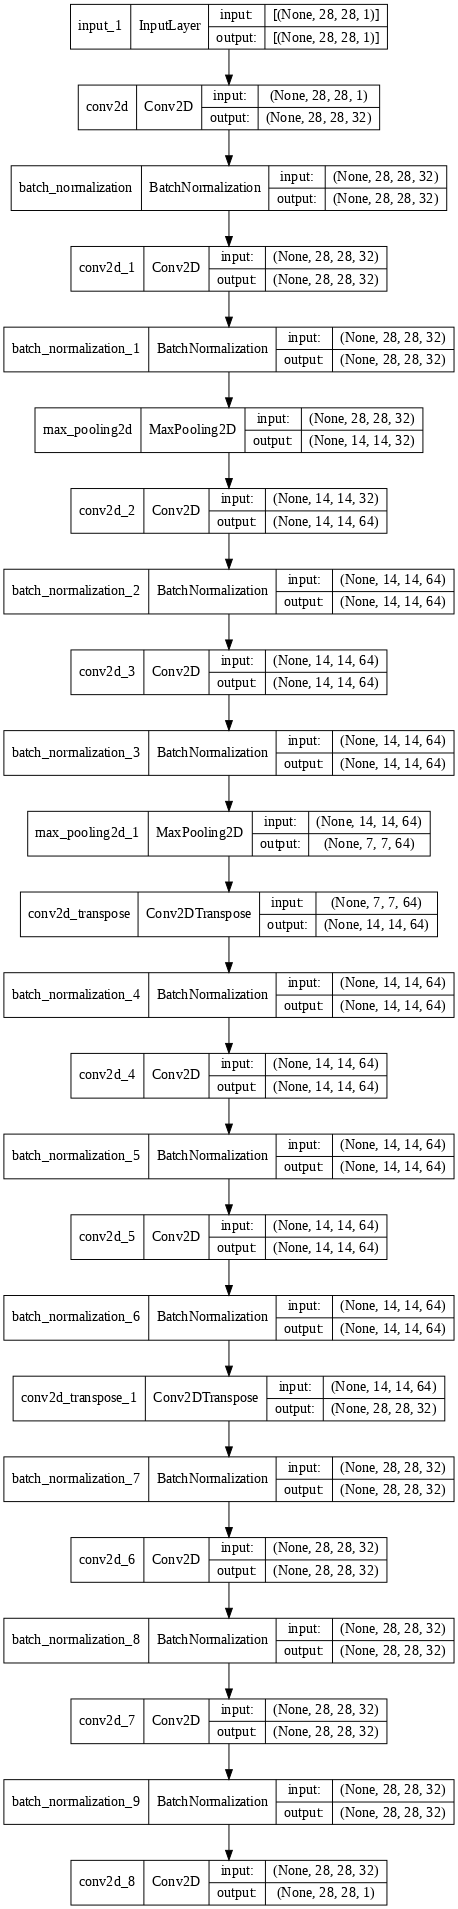

In [ ]:
# Визуальная схема архитектуры модели
utils.plot_model(ae_mnist, 
                 dpi=70,                  # число точек на дюйм (дюйм = 2.54 см)
                 show_shapes=True         # отображение ожидаемых форм входных и выходных тензоров каждого слоя
                 )

In [ ]:
# Обучение модели автокодировщика, на входе и выходе одни и те же данные
history = ae_mnist.fit(x_train_mnist, y_train_mnist,
                       epochs=100,
                       batch_size=256,
                       validation_data = (x_test_mnist, y_test_mnist))

Epoch 1/100
17/17 [==============================] - 2s 116ms/step - loss: 0.0541 - val_loss: 0.0601
Epoch 2/100
17/17 [==============================] - 2s 109ms/step - loss: 0.0538 - val_loss: 0.0599
Epoch 3/100
17/17 [==============================] - 2s 113ms/step - loss: 0.0536 - val_loss: 0.0596
Epoch 4/100
17/17 [==============================] - 2s 110ms/step - loss: 0.0533 - val_loss: 0.0601
Epoch 5/100
17/17 [==============================] - 2s 110ms/step - loss: 0.0530 - val_loss: 0.0597
Epoch 6/100
17/17 [==============================] - 2s 108ms/step - loss: 0.0528 - val_loss: 0.0602
Epoch 7/100
17/17 [==============================] - 2s 109ms/step - loss: 0.0525 - val_loss: 0.0604
Epoch 8/100
17/17 [==============================] - 2s 109ms/step - loss: 0.0523 - val_loss: 0.0596
Epoch 9/100
17/17 [==============================] - 2s 113ms/step - loss: 0.0520 - val_loss: 0.0599
Epoch 10/100
17/17 [==============================] - 2s 109ms/step - loss: 0.0517 - val_lo

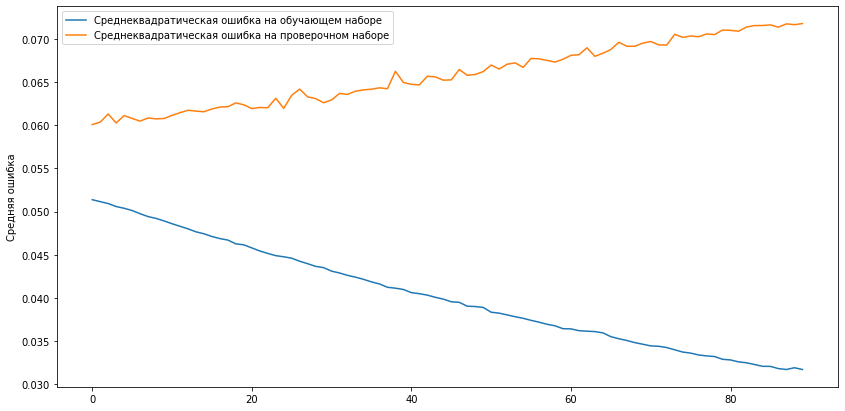

In [ ]:
# Вывод графиков процесса обучения
plt.figure(figsize=(14,7))
plt.plot(history.history['loss'][10:], 
         label='Среднеквадратическая ошибка на обучающем наборе')
plt.plot(history.history['val_loss'][10:], 
         label='Среднеквадратическая ошибка на проверочном наборе')
plt.ylabel('Средняя ошибка')
plt.legend()
plt.show()

In [ ]:
# Получение предсказания автокодировщика на тренировочной, валидационной и тестовой выборках
pred_train_mnist = ae_mnist.predict(x_train_mnist)
pred_test_mnist = ae_mnist.predict(x_test_mnist)
pred_test_mnist1 = ae_mnist.predict(x_test_mnist1)

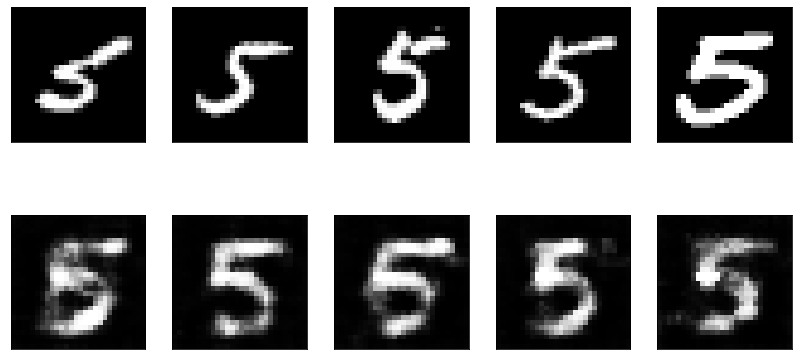

In [ ]:
# Сравнение исходных и восстановленных картинок из валидационной выборки
plot_images(x_test_mnist, pred_test_mnist)

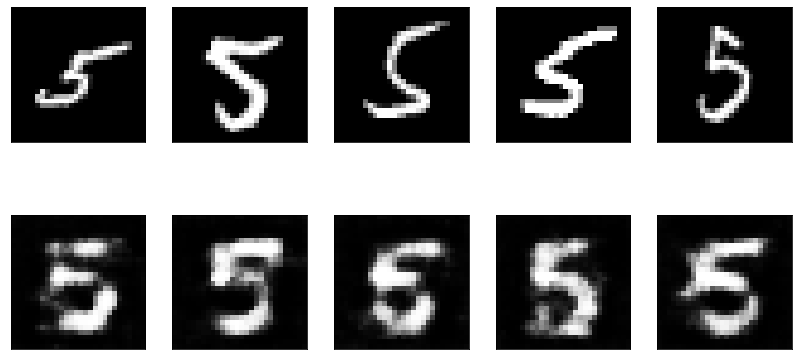

In [ ]:
# Сравнение исходных и восстановленных картинок из тестовой выборки
plot_images(x_test_mnist1, pred_test_mnist1)